# COVID-19 face mask detector with CNN, OpenCV

In [1]:
import cv2,os
import numpy as np
from keras.utils import np_utils
import imutils
import pytesseract
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
%matplotlib inline

# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [2]:
np.__version__

'1.18.1'

In [3]:
cv2.__version__

'4.3.0'

In [4]:
tf.__version__

'2.2.0'

In [5]:
keras.__version__

'2.4.3'

#### 데이터 라벨 만들기

In [6]:
data_path='../data/mask_data/'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels))

In [7]:
label_dict

{'without_mask': 0, 'with_mask': 1}

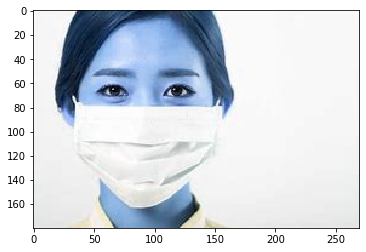

In [8]:
img = cv2.imread('../data/mask_data/with_mask/601-with-mask.jpg')
plt.imshow(img)

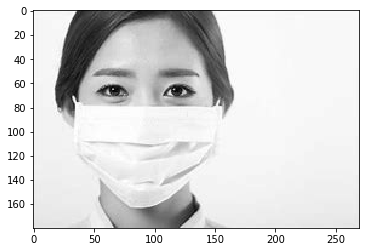

In [9]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap = 'gray')

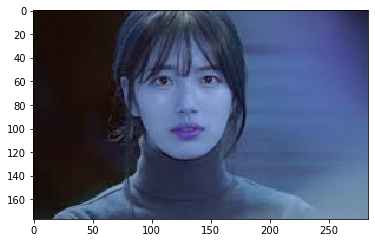

In [10]:
img = cv2.imread('../data/mask_data/without_mask/551.jpg')
plt.imshow(img)

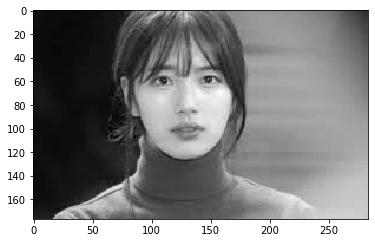

In [11]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap = 'gray')

### #데이터 불러오기

In [12]:
data=[]
target=[]

for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
            resized=cv2.resize(gray,(100, 100))
            data.append(resized)
            target.append(label_dict[category])

        except Exception as e:
            print('Exception:', e)

In [13]:
categories

['without_mask', 'with_mask']

In [14]:
folder_path

'../data/mask_data/with_mask'

In [15]:
img_names[:5]

['0-with-mask.jpg',
 '101-with-mask.jpg',
 '106-with-mask.jpg',
 '108-with-mask.jpg',
 '109-with-mask.jpg']

In [16]:
data[:3]

[array([[218, 215, 212, ..., 168, 155, 152],
        [215, 212, 204, ..., 189, 183, 159],
        [201, 198, 190, ..., 162, 167, 158],
        ...,
        [ 33,  53,  70, ...,  14,  14,  15],
        [ 31,  54,  77, ...,  19,  19,  17],
        [ 33,  56,  77, ...,  25,  27,  23]], dtype=uint8),
 array([[180, 173, 175, ..., 186, 163, 137],
        [178, 174, 175, ..., 174, 151, 135],
        [174, 178, 177, ..., 153, 134, 145],
        ...,
        [203, 201, 196, ..., 153, 152, 161],
        [201, 200, 195, ..., 159, 156, 159],
        [194, 196, 199, ..., 155, 166, 143]], dtype=uint8),
 array([[255, 255, 255, ..., 254, 254, 254],
        [255, 255, 255, ..., 254, 254, 254],
        [254, 254, 250, ..., 228, 218, 209],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)]

In [17]:
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0], 100, 100, 1))
target=np.array(target)

new_target=np_utils.to_categorical(target)

np.save('data', data)
np.save('target', new_target)

In [18]:
new_target

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [19]:
data=np.load('data.npy')
target=np.load('target.npy')

In [20]:
data.shape

(615, 100, 100, 1)

In [21]:
target.shape

(615, 2)

In [22]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.python.keras.optimizer_v2 import rmsprop

### #학습용 데이터와 검증용 데이터 세트로 분할하기

In [23]:
train_data,test_data,train_target,test_target=train_test_split(data,target, test_size=0.2, random_state=42)

In [24]:
train_data.shape

(492, 100, 100, 1)

### *Data augmentation to improve generalization

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(rotation_range=20, 
                         zoom_range=0.2, 
                         width_shift_range=0.2, 
                         height_shift_range=0.2, 
                         shear_range=0.15, 
                         horizontal_flip=True,
                         fill_mode="nearest")

### *Hyperparameter Tuning With Bayesian Optimization

In [26]:
input_shape=data.shape[1:]
input_shape

(100, 100, 1)

In [27]:
def get_model(input_shape, dropout2_rate=0.5):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,
                     name="conv2d_1"))
    model.add(Conv2D(64, (3, 3), activation='relu', name="conv2d_2"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="maxpool2d_1"))
    model.add(Dropout(0.25, name="dropout_1"))
    model.add(Flatten(name="flatten"))
    model.add(Dense(128, activation='relu', name="dense_1"))
    model.add(Dropout(dropout2_rate, name="dropout_2"))
    model.add(Dense(2, activation='softmax', name="dense_2"))
    return model

In [28]:
def fit_with(input_shape, verbose, dropout2_rate, lr):

    model = get_model(input_shape, dropout2_rate)
    
    optimizer = rmsprop.RMSProp(learning_rate=lr)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    model.fit(train_data, train_target, epochs=10,
              batch_size=4, verbose=verbose)

    score = model.evaluate(test_data, test_target, steps=10, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return score[1]

In [29]:
from functools import partial

verbose = 1
fit_with_partial = partial(fit_with, input_shape, verbose)

In [30]:
from bayes_opt import BayesianOptimization

pbounds = {'dropout2_rate': (0.1, 0.5), 'lr': (1e-4, 1e-2)}

optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=pbounds,
    verbose=2, 
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=10)

for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

|   iter    |  target   | dropou... |    lr     |
-------------------------------------------------
Epoch 1/10
123/123 [==============================] - 25s 200ms/step - loss: 5.6166 - accuracy: 0.6321
Epoch 2/10
123/123 [==============================] - 25s 203ms/step - loss: 5.6111 - accuracy: 0.6341
Epoch 3/10
123/123 [==============================] - 25s 204ms/step - loss: 5.6111 - accuracy: 0.6341
Epoch 4/10
123/123 [==============================] - 24s 197ms/step - loss: 5.6111 - accuracy: 0.6341
Epoch 5/10
123/123 [==============================] - 24s 198ms/step - loss: 5.6111 - accuracy: 0.6341
Epoch 6/10
123/123 [==============================] - 25s 202ms/step - loss: 5.6111 - accuracy: 0.6341
Epoch 7/10
123/123 [==============================] - 25s 201ms/step - loss: 5.6111 - accuracy: 0.6341
Epoch 8/10
123/123 [==============================] - 25s 201ms/step - loss: 5.6111 - accuracy: 0.6341
Epoch 9/10
123/123 [==============================] - 25s 202ms/step - loss:

In [31]:
print(optimizer.max)

{'target': 0.8373983502388, 'params': {'dropout2_rate': 0.4018635446446502, 'lr': 0.0001}}


### * Build the CNN model

In [32]:
model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3),input_shape=data.shape[1:], activation='relu'))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4018635446446502))
model.add(Dense(2, activation='softmax'))

In [33]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50)
checkpoint = ModelCheckpoint(
    '{epoch:03d}-{val_loss:.4f}.model',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='auto')

### *Train the model

In [ ]:
history=model.fit(aug.flow(train_data, train_target), 
                  epochs=200, 
                  batch_size=4,
                  callbacks=[checkpoint, early_stopping],
                  validation_data=(test_data, test_target))

print(model.evaluate(test_data,test_target))

In [47]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 98, 98, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 147456)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               18874496  
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)             

### *Evaluate the model : best model (100-0.3327.model)

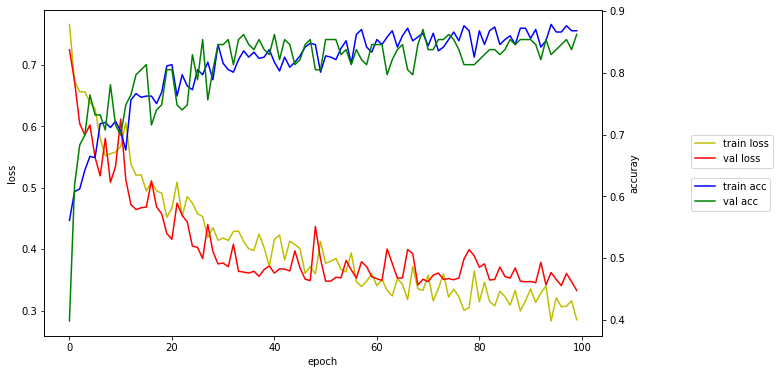

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(10,6))
acc_ax = loss_ax.twinx()

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

acc_ax.legend(loc='upper left', bbox_to_anchor=(1.15, 0.5))
loss_ax.legend(loc='lower left', bbox_to_anchor=(1.15, 0.5))

plt.show()

# COVID-19 face mask detector in real-time video streams with OpenCV

In [42]:
import cv2
import numpy as np
from keras.models import load_model
from twilio.rest import Client
import time

labels_dict={1:'with_mask', 0:'without_mask'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [3]:
#video stream source : webcam or recorded video 

source=cv2.VideoCapture(0)
# cap = cv2.VideoCapture('test_mask.mp4')

In [4]:
# video output

fourcc = cv2.VideoWriter_fourcc('X', 'V', 'I', 'D')
out = cv2.VideoWriter('output.avi', fourcc, 20, (640,480))

In [ ]:
# warning sound in case of without_mask

import pygame, sys
from pygame import mixer

pygame.init()
pygame.mixer.init()

sound = mixer.Sound('alarm.wav')

In [ ]:
# face recognition/classifier : haar feature
face_clsfr=cv2.CascadeClassifier('../data/haarcascade_frontalface_default.xml')

# face mask detector
model = load_model('100-0.3327.model')

# SMS API Twilio
account_sid = "ACxxxxxxxxxXxxxx"
auth_token  = "93xxxxxxxxxxx"

myTwilioNumber = "+1xxxxxxxx"
destCellPhone  = "+82010xxxxxxxx"


while(True):

    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for x,y,w,h in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        
        if(labels_dict[label] == 'with_mask'):
            print("No Beep")
        else:
            sound.play()
            print("Beep")
            client = Client(account_sid, auth_token)
            client.messages.create(body = 'Test MSG: No Mask', 
                                   from_ = myTwilioNumber, 
                                   to = destCellPhone)   
            time.sleep(2)
        
        cv2.putText(
          img, "{}: {:.2f}%".format(labels_dict[label], np.max(result) * 100),            
          (x, y-10),
          cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    out.write(img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

source.release()
out.release()

cv2.destroyAllWindows()

#### Example : capturing a video

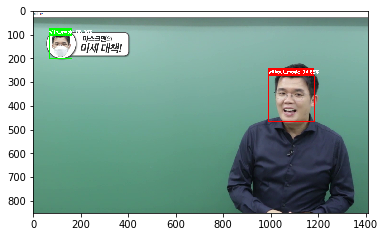

In [50]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('capture_result.png')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)